# CSUB First Year Student Retention Prediction
**Making a binary prediction of whether a first year student will return the following semester or not**

1. [Data Prep](#Data-Prep)
  1. [Import Libraries](#Import-Libraries)
  2. [Import Data from AWS S3](#Import-Data-from-AWS-S3)
  3. [Examine Data Types](#Examine-Data-Types)
  4. [Check Correlations](#Check-Correlations)
  5. [Check Null Values](#Check-Null-Values)
  6. [Exploration Category Value](#Exploration-Category-Value)
  7. [Data Conversion](#Data-Conversion)
  8. [Final Data Exploration](#Final-Data-Exploration)
2. [Implementation](#Implementation)
  1. [Dataset Split in Training, Validation, and Testing](#Dataset-Split-in-Training,-Validation,-and-Testing)
  2. [Training the Linear Model](#Training-the-Linear-Model)
3. [Deploy for Real Time Prediction](#Deploy-for-Real-Time-Prediction)
  1. [Set up hosting for the Model](#Set-up-hosting-for-the-Model)
4. [Evaluate the Model for use](#Evaluate-the-Model-for-use)
  1. [Check Single Record](#Check-Single-Record)
  2. [Check a set of Records](#Check-a-set-of-Records)
  3. [Display Prediction Results](#Display-Prediction-Results)
  4. [Final Evaluation Result](#Final-Evaluation-Result)
5. [Delete the Endpoint](#Delete-the-Endpoint)

## Data Prep
<b>Examine student cohort data</b><br>
Linear Learner accepts CSV or recordIO-warpped protobuf
- CSV = No headers and label must be in the first column
- Check correlation and Standard Deviation
- Feature engineering
- Convert categorical data to numeric value
Reference: https://www.datacamp.com/community/tutorials/categorical-data

### Import Libraries
- Pandas, Numpy, sklearn, boto3, sagemaker

In [1]:
#Import libraries
import pandas as pd
import numpy as np
from numpy import array
from sklearn.metrics import f1_score
import copy
import boto3
import re
from sagemaker import get_execution_role
import os
import io
import time
import json
import sagemaker.amazon.common as smac
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

bucket = 'sagemaker-student-retention'

#To check the user role or who I am
role = get_execution_role()  

### Import Data from AWS S3 ###
- File format: csv
- Bucket: sagemaker-student-retention
- File name: student_cohort_data.csv

In [2]:
#Instantiate an instance of the Boto3 SDK and scope to the S3 bucket
s3 = boto3.resource('s3')

#KEY very common phrase used to describe an S3 object
KEY = 'student_cohort_data.csv'

#Download the dataset to the notebook instance
s3.Bucket(bucket).download_file(KEY, 'student_cohort_data.csv')

In [4]:
#Introduction to Pandas
data = pd.read_csv('student_cohort_data.csv')

#Check data
data.head()

,StudentID,Athlete,Citizen,Conc Used Code,Country,% of Male,Ethnicity,First Gen,Gender,Inst Of Origin,...,Program Grp,School Used,Stu Category,Stu Desc,Term Desc,Unit Load,URM,Veteran Stat,Dropped,age
0,1,NaN,Resident,9012,United States,0,WHITE,3,Female,CA High School,...,PHYS_ENG,NSME,1,First-Time Freshmen,Fall 2017,8,N,-,Y,20
1,2,NaN,Resident,21051,United States,1,HISPANIC,3,Male,CA High School,...,CRJU,SSE,1,First-Time Freshmen,Fall 2017,13,Y,-,Y,19
2,3,NaN,Resident,121,United States,0,ASIAN,3,Female,CA High School,...,NURS,NSME,1,First-Time Freshmen,Fall 2017,15,N,-,Y,18
3,4,NaN,Resident,4011,United States,1,WHITE,1,Male,CA High School,...,BIOL_HBIO,NSME,1,First-Time Freshmen,Fall 2017,14,N,-,Y,18
4,5,NaN,Resident,9091,United States,1,HISPANIC,3,Male,CA High School,...,CPEL_ENG,NSME,1,First-Time Freshmen,Fall 2017,15,Y,-,Y,18


### Examine Data Types ###
Check data types within the dataframe

In [5]:
#Gather information of the data type
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 24 columns):
StudentID         2429 non-null int64
Athlete           0 non-null float64
Citizen           2429 non-null object
Conc Used Code    2429 non-null int64
Country           2429 non-null object
% of Male         2429 non-null int64
Ethnicity         2429 non-null object
First Gen         2429 non-null int64
Gender            2429 non-null object
Inst Of Origin    2429 non-null object
Load Stat         2429 non-null object
Major Used        2429 non-null object
Parent Grp        2429 non-null object
Pell Elig         2429 non-null object
Program Grp       2429 non-null object
School Used       2429 non-null object
Stu Category      2429 non-null int64
Stu Desc          2429 non-null object
Term Desc         2429 non-null object
Unit Load         2429 non-null int64
URM               2429 non-null object
Veteran Stat      2429 non-null object
Dropped           2429 non-null object
age 

### Check Correlations ###
An example to check correlationships between the features
- Gender vs Unit Load

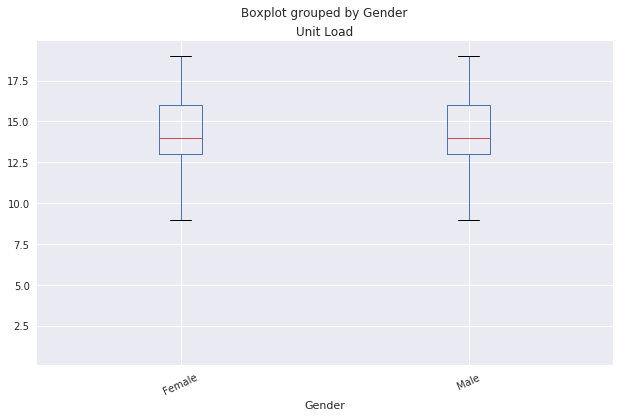

In [74]:
# One of the common way to analyze the relationship between a categorical feature and a continuous feature is to plot 
# a boxplot. The boxplot is a simple way of representing statistical data on a plot in which a rectangle is drawn to represent
# the second and third quartiles, usually with a vertical line inside to indicate the median value. The lower and upper
# quartiles are shown as horizontal lines at either side of the rectangle.

data.boxplot('Unit Load', 'Gender', rot = 25, figsize = (10,6))

### Check Null Values ###

In [75]:
#Next, we need to check all the null values in the dataset
print(data.isnull().sum())

StudentID            0
Athlete           2429
Citizen              0
Conc Used Code       0
Country              0
% of Male            0
Ethnicity            0
First Gen            0
Gender               0
Inst Of Origin       0
Load Stat            0
Major Used           0
Parent Grp           0
Pell Elig            0
Program Grp          0
School Used          0
Stu Category         0
Stu Desc             0
Term Desc            0
Unit Load            0
URM                  0
Veteran Stat         0
Dropped              0
age                  0
dtype: int64


### Exploration Category Value ###

In [76]:
#Another Exploratory Data Analysis (EDA) step that we can do on categorical features is the frequency distribution of 
#categories within the feature, which can be done with the .value_counts() method:

print(data['Ethnicity'].value_counts())

#to count distinct categories
print("\nCount distinct categories: ")
print(data['Ethnicity'].value_counts().count())

HISPANIC                             1686
WHITE                                 325
ASIAN                                 181
BLACK                                 120
SEE MULTI-RACE                         76
DECLINED TO STATE                      28
AMERICAN INDIAN OR ALASKAN NATIVE      10
HAWAIIAN OR PACIFIC ISLANDER            3
Name: Ethnicity, dtype: int64

Count distinct categories: 
8


In [ ]:
#A code to display plot style - default settings 
#sns.axes_style()

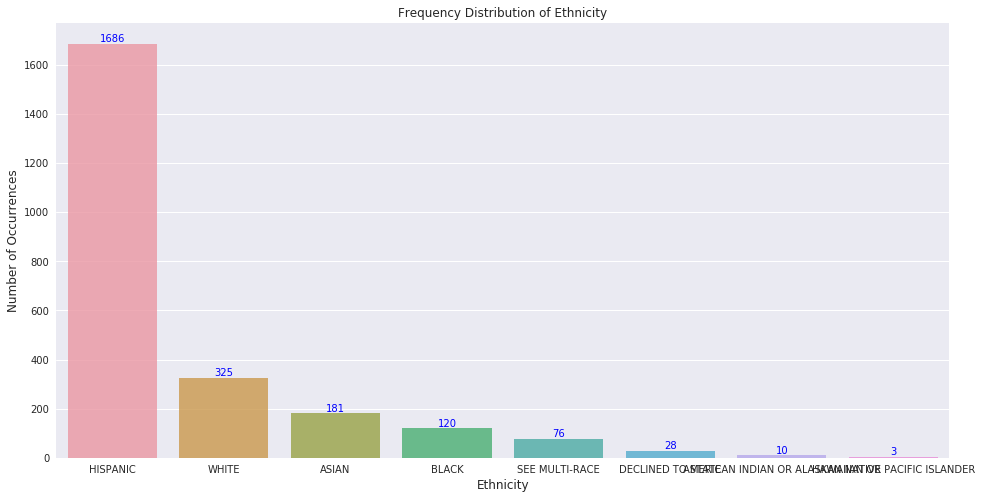

In [118]:
#Visual exploration is often the most effective way to extract information between variables
#Below is a basic template to plot a barplot of the frequency distribution of a categorical feature using the seaborn package, 
#which shows the frequency distribution of the Ethnicity column.

Ethnicity_Count = data['Ethnicity'].value_counts()
sns.set_style("darkgrid", {"axes.facecolor": ".8"})
sns.set(rc={'figure.figsize':(16,8)})
sns.barplot(Ethnicity_Count.index, Ethnicity_Count.values, alpha=0.8, label='small')
plt.title('Frequency Distribution of Ethnicity')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ethnicity', fontsize=12)

#Get current axis on current figure
ax = plt.gca()

#Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=10, color='blue', ha='center', va='bottom')
    
plt.show()

In [78]:
#Auto generate number for category data
labels = data['Ethnicity'].astype('category').cat.categories.tolist()
replace_country = {'Ethnicity':{k: v for k, v in zip(labels, list(range(1,len(labels)+1)))}}
print(replace_country)

#Make another copy of the data that stores converted value
cat_data_replace = data.copy()

#Replace country category to numeric value
cat_data_replace.replace(replace_country, inplace=True)

#verify data
#print(cat_data_replace.head())

{'Ethnicity': {'AMERICAN INDIAN OR ALASKAN NATIVE': 1, 'ASIAN': 2, 'BLACK': 3, 'DECLINED TO STATE': 4, 'HAWAIIAN OR PACIFIC ISLANDER': 5, 'HISPANIC': 6, 'SEE MULTI-RACE': 7, 'WHITE': 8}}


### Data Conversion ###
<b>Convert category data to numerical value</b>

In [95]:
#Use Label Enabling Technique to auto convert categorical value
#Set object type to category

cat_data_lc = data.copy()
cat_data_lc['Citizen'] = cat_data_lc['Citizen'].astype('category')
cat_data_lc['Ethnicity'] = cat_data_lc['Ethnicity'].astype('category')
cat_data_lc['Gender'] = cat_data_lc['Gender'].astype('category')
cat_data_lc['Inst Of Origin'] = cat_data_lc['Inst Of Origin'].astype('category')
cat_data_lc['Load Stat'] = cat_data_lc['Load Stat'].astype('category')
cat_data_lc['Dropped'] = cat_data_lc['Dropped'].astype('category')
cat_data_lc['Parent Grp'] = cat_data_lc['Parent Grp'].astype('category')
cat_data_lc['Program Grp'] = cat_data_lc['Program Grp'].astype('category')
cat_data_lc['Pell Elig'] = cat_data_lc['Pell Elig'].astype('category')
cat_data_lc['School Used'] = cat_data_lc['School Used'].astype('category')
cat_data_lc['URM'] = cat_data_lc['URM'].astype('category')

#print(cat_data_lc.dtypes)
cat_data_lc['Citizen'] = cat_data_lc['Citizen'].cat.codes
cat_data_lc['Ethnicity'] = cat_data_lc['Ethnicity'].cat.codes
cat_data_lc['Gender'] = cat_data_lc['Gender'].cat.codes
cat_data_lc['Inst Of Origin'] = cat_data_lc['Inst Of Origin'].cat.codes
cat_data_lc['Load Stat'] = cat_data_lc['Load Stat'].cat.codes
cat_data_lc['Parent Grp'] = cat_data_lc['Parent Grp'].cat.codes
cat_data_lc['Program Grp'] = cat_data_lc['Program Grp'].cat.codes
cat_data_lc['Pell Elig'] = cat_data_lc['Pell Elig'].cat.codes
cat_data_lc['School Used'] = cat_data_lc['School Used'].cat.codes
cat_data_lc['Dropped'] = cat_data_lc['Dropped'].cat.codes
cat_data_lc['URM'] = cat_data_lc['URM'].cat.codes

#Add an additional column of 'US' and set value to 1 if the country is United States, and everywhere elses to value 0
cat_data_lc['Country of Birth'] = np.where(cat_data_lc['Country'].str.contains('United States'), 1, 0) 

#Drop all the columns that no longer needed
cat_data_lc = cat_data_lc.drop(['Country', 'StudentID', 'Athlete', 'Conc Used Code', '% of Male', 'Stu Desc', 'Term Desc', 'Major Used', 'Veteran Stat'], axis=1)

#Move Targe column into the first column
dropped = cat_data_lc['Dropped']
cat_data_lc.drop(labels=['Dropped'], axis=1, inplace=True)
cat_data_lc.insert(0, 'Dropped', dropped)

cat_data_lc.head()

,Dropped,Citizen,Ethnicity,First Gen,Gender,Inst Of Origin,Load Stat,Parent Grp,Pell Elig,Program Grp,School Used,Stu Category,Unit Load,URM,age,Country of Birth
0,1,1,7,3,0,0,1,1,0,23,3,1,8,1,20,1
1,1,1,5,3,1,0,0,0,1,9,4,1,13,2,19,1
2,1,1,1,3,0,0,0,0,1,21,3,1,15,1,18,1
3,1,1,7,1,1,0,0,1,1,4,3,1,14,1,18,1
4,1,1,5,3,1,0,0,1,1,8,3,1,15,2,18,1


### Final Data Exploration

Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:

- The total number of students, n_students.
- The total number of features for each student, n_features.
- The number of those students who returned, n_returned.
- The number of those students who dropped, n_dropped.
- The retention rate of the students in percent (%).

In [96]:
# TODO: Calculate number of students
n_students = cat_data_lc.shape[0]

# TODO: Calculate number of features
n_features = cat_data_lc.shape[1] - 1

# TODO: Calculate passing students
# Data filtering using .loc[rows, columns]
dropped_cnt = cat_data_lc.loc[cat_data_lc.Dropped == 1, 'Dropped']
n_dropped = dropped_cnt.shape[0]

# TODO: Calculate failing students
returned = cat_data_lc.loc[cat_data_lc.Dropped == 0, 'Dropped']
n_returned = returned.shape[0]

# TODO: Calculate graduation rate
total = float(n_dropped + n_returned)
retention_rate = float(n_returned * 100 / total)

# Print the results
print("Total number of students: " + str(n_students))
print("Number of features: " + str(n_features))
print("Number of students who returned: " + str(n_returned))
print("Number of students who dropped: " + str(n_dropped))
print("Retention rate of the dataset: %.2f " % retention_rate)

Total number of students: 2429
Number of features: 15
Number of students who returned: 2297
Number of students who dropped: 132
Retention rate of the dataset: 94.57 


## Implementation

So far, we have converted all categorical features into numeric values. For the next step, we split the data (both features and corresponding labels) into training, validation, and test sets. 

### Dataset Split in Training, Validation, and Testing
- Using 1457 training points (60%), 486 validating points (20%), and 486 testing points (20%). 
- Set a random_state for the function(s)
- Store the results train, validate, test

In [97]:
train, validate, test = np.split(cat_data_lc.sample(frac=1), [int(.6*len(cat_data_lc)), int(.8*len(cat_data_lc))])

train.head()

,Dropped,Citizen,Ethnicity,First Gen,Gender,Inst Of Origin,Load Stat,Parent Grp,Pell Elig,Program Grp,School Used,Stu Category,Unit Load,URM,age,Country of Birth
1735,0,1,7,1,1,0,0,0,0,30,2,1,13,1,18,1
1211,0,1,4,1,1,0,0,0,0,30,2,1,13,1,18,1
1372,0,1,7,1,1,1,0,1,1,4,3,1,15,1,17,1
1843,0,1,2,2,0,0,0,0,0,7,0,1,13,2,18,1
290,0,1,7,4,0,0,0,1,1,4,3,1,14,1,18,1


In [98]:
test.head()

,Dropped,Citizen,Ethnicity,First Gen,Gender,Inst Of Origin,Load Stat,Parent Grp,Pell Elig,Program Grp,School Used,Stu Category,Unit Load,URM,age,Country of Birth
475,0,0,5,3,0,0,0,0,0,7,0,1,15,2,19,0
452,0,1,5,3,1,0,0,0,1,3,1,1,15,2,18,1
4,1,1,5,3,1,0,0,1,1,8,3,1,15,2,18,1
436,0,1,5,3,0,0,0,0,1,21,3,1,14,2,18,1
345,0,1,7,1,0,0,0,0,0,19,0,1,15,1,18,1


In [99]:
validate.head()

,Dropped,Citizen,Ethnicity,First Gen,Gender,Inst Of Origin,Load Stat,Parent Grp,Pell Elig,Program Grp,School Used,Stu Category,Unit Load,URM,age,Country of Birth
2333,0,1,7,2,1,0,0,1,1,8,3,1,13,1,18,1
1505,0,1,5,3,0,0,0,0,1,28,4,1,14,2,18,1
1771,0,1,5,3,0,0,0,0,1,21,3,1,13,2,19,1
1947,0,1,5,3,0,0,0,0,0,26,4,1,13,2,19,1
1861,0,1,1,3,0,0,0,1,0,4,3,1,14,1,18,1


In [100]:
train['Dropped'].value_counts()

0    1381
1      76
Name: Dropped, dtype: int64

In [101]:
test['Dropped'].value_counts()

0    459
1     27
Name: Dropped, dtype: int64

In [102]:
validate['Dropped'].value_counts()

0    457
1     29
Name: Dropped, dtype: int64

In [103]:
# Show the results of the split
print("Training set has " + str(train.shape[0]) + " samples")
print("Testing set has " + str(test.shape[0]) + " samples")
print("Validate set has " + str(validate.shape[0]) + " samples")

Training set has 1457 samples
Testing set has 486 samples
Validate set has 486 samples


### Training the Linear Model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed. In this example that takes between 7 and 11 minutes. Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

In [104]:
#Save training data into train.csv and stored at S3 bucket
np.savetxt('train.csv', train, delimiter=',')
key = 'train.csv'
s3_train_data = 's3://{}/{}'.format(bucket,key)
boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('train.csv')
print('Done writing to {}'.format(s3_train_data))

Done writing to s3://sagemaker-student-retention/train.csv


In [105]:
#Save validation data into validation.csv and stored at S3 bucket
np.savetxt('validation.csv', validate, delimiter=',')
key1 = 'validation.csv'
s3_validation_data = 's3://{}/{}'.format(bucket,key1)
boto3.Session().resource('s3').Bucket(bucket).Object(key1).upload_file('validation.csv')
print('Done writing to {}'.format(s3_validation_data))

Done writing to s3://sagemaker-student-retention/validation.csv


In [106]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker

container = get_image_uri(boto3.Session().region_name, 'linear-learner')
output_location = 's3://sagemaker-student-retention/output'

sess = sagemaker.Session()
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       train_volume_size = 10,
                                       train_max_run = 3600,
                                       input_mode= 'File',
                                       output_path=output_location,
                                       sagemaker_session=sess)

linear.set_hyperparameters(binary_classifier_model_selection_criteria='f1',
                           feature_dim=15,
                           predictor_type='binary_classifier',
                           mini_batch_size=10)

ll_train_data = sagemaker.session.s3_input(
    s3_train_data, 
    distribution='FullyReplicated',
    content_type='text/csv;label_size=1', 
    s3_data_type='S3Prefix')

ll_validation_data = sagemaker.session.s3_input(
    s3_validation_data, 
    distribution='FullyReplicated',
    content_type='text/csv;label_size=1', 
    s3_data_type='S3Prefix')

linear.fit({'train':ll_train_data, 'validation': ll_validation_data})

2019-05-11 18:34:43 Starting - Starting the training job...
2019-05-11 18:34:45 Starting - Launching requested ML instances......
2019-05-11 18:35:54 Starting - Preparing the instances for training......
2019-05-11 18:36:54 Downloading - Downloading input data...
2019-05-11 18:37:35 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[05/11/2019 18:37:37 INFO 139716895201088] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.19811713013155707, "sum": 0.19811713013155707, "min": 0.19811713013155707}}, "EndTime": 1557599868.983958, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1557599868.983899}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.19878648951135833, "sum": 0.19878648951135833, "min": 0.19878648951135833}}, "EndTime": 1557599868.984039, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1557599868.984022}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.1984505963736567, "sum": 0.1984505963736567, "min": 0.1984505963736567}}, "EndTime": 1557599868.984094, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear 


2019-05-11 18:38:11 Uploading - Uploading generated training model#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.195931229488603, "sum": 0.195931229488603, "min": 0.195931229488603}}, "EndTime": 1557599880.32347, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1557599880.323406}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.19672837993194317, "sum": 0.19672837993194317, "min": 0.19672837993194317}}, "EndTime": 1557599880.323551, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1557599880.323534}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.19611780047416688, "sum": 0.19611780047416688, "min": 0.19611780047416688}}, "EndTime": 1557599880.323607, "Dimensions": {"model": 2, "


2019-05-11 18:38:18 Completed - Training job completed
Billable seconds: 84


## Deploy for Real Time Prediction

### Set up hosting for the Model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [109]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium')

----------------------------------------------------------------------------------------------------!

## Evaluate the Model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [110]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

modelT = np.array(train.iloc[1:2, 1:])

modelT

array([[ 1,  4,  1,  1,  0,  0,  0,  0, 30,  2,  1, 13,  1, 18,  1]])

In [111]:
train.head(2)

,Dropped,Citizen,Ethnicity,First Gen,Gender,Inst Of Origin,Load Stat,Parent Grp,Pell Elig,Program Grp,School Used,Stu Category,Unit Load,URM,age,Country of Birth
1735,0,1,7,1,1,0,0,0,0,30,2,1,13,1,18,1
1211,0,1,4,1,1,0,0,0,0,30,2,1,13,1,18,1


### Check Single Record
Now let's try getting a prediction for a single record.

In [112]:
result = linear_predictor.predict(modelT[0])
print(result)

{'predictions': [{'score': 0.05843328684568405, 'predicted_label': 0.0}]}


OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think the digit is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the image is a 0, while `0` denotes that we are predicting the image is not of a 0.

Let's do a whole batch of records and evaluate our predictive accuracy.

### Check a set of Records

In [113]:
model_test = np.array(test.iloc[:, 1:])
model_test

array([[ 0,  5,  3, ...,  2, 19,  0],
       [ 1,  5,  3, ...,  2, 18,  1],
       [ 1,  5,  3, ...,  2, 18,  1],
       ...,
       [ 1,  5,  3, ...,  2, 18,  1],
       [ 1,  5,  3, ...,  2, 18,  1],
       [ 1,  5,  3, ...,  2, 18,  1]])

In [115]:
import numpy as np

predictions = []
for array in model_test:
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

# Convert result to int
predictions.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

### Display Prediction Results

In [116]:
import pandas as pd

test['Predicted'] = predictions.astype(int)

test.head()

,Dropped,Citizen,Ethnicity,First Gen,Gender,Inst Of Origin,Load Stat,Parent Grp,Pell Elig,Program Grp,School Used,Stu Category,Unit Load,URM,age,Country of Birth,Predicted
475,0,0,5,3,0,0,0,0,0,7,0,1,15,2,19,0,0
452,0,1,5,3,1,0,0,0,1,3,1,1,15,2,18,1,0
4,1,1,5,3,1,0,0,1,1,8,3,1,15,2,18,1,0
436,0,1,5,3,0,0,0,0,1,21,3,1,14,2,18,1,0
345,0,1,7,1,0,0,0,0,0,19,0,1,15,1,18,1,0


### Final Evaluation Result

In [117]:
comp = pd.DataFrame(test, columns=['Dropped', 'Predicted'])
comp['Not Matched'] = np.where(comp['Dropped'] != comp['Predicted'], comp['Dropped'], np.nan)

total_row = comp['Dropped'].count()
mismatched = comp['Not Matched'].count() 
accuracy = float((total_row - mismatched) * 100 / total_row)

# Print the results
print("accuracy rate of the prediction: %2f " % accuracy)

accuracy rate of the prediction: 89.917695 


## Delete the Endpoint

Run the delete_endpoint line in the cell below so you won't be billed for usage of additional resources.  
This will remove the hosted endpoint we created and avoid any charges from a stray instance being left on.

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)